In [1]:
import transformers

In [17]:
from torch.optim import lr_scheduler
from torch import optim
import torch
from typing import Optional
import argparse
import os
import numpy as np
import json
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry
from scripts import BinaryMaskLoss, Trainer, DatasetSplitter, create_datasets, get_threshold, split_batch_images_labels, MetricsCalculator


In [2]:
from deepspeed.runtime.zero.stage3 import estimate_zero3_model_states_mem_needs_all_live

## specify the model you want to train on your device
model = sam_model_registry['vit_l  ']('weights/MySam/BinaryMaskLoss/lr0.001_bs1_pwTrue_fOnlyKeepMid_add/best_weights.pth')
## estimate the memory cost (both CPU and GPU)
estimate_zero3_model_states_mem_needs_all_live(model, num_gpus_per_node=1, num_nodes=1)


[2024-04-15 21:08:35,386] [INFO] [real_accelerator.py:191:get_accelerator] Setting ds_accelerator to cuda (auto detect)
Estimated memory needed for params, optim states and gradients for a:
HW: Setup with 1 node, 1 GPU per node.
SW: Model with 182M total params, 3M largest layer params.
  per CPU  |  per GPU |   Options
    4.58GB |   0.01GB | offload_param=cpu , offload_optimizer=cpu , zero_init=1
    4.58GB |   0.01GB | offload_param=cpu , offload_optimizer=cpu , zero_init=0
    4.08GB |   0.35GB | offload_param=none, offload_optimizer=cpu , zero_init=1
    4.08GB |   0.35GB | offload_param=none, offload_optimizer=cpu , zero_init=0
    0.02GB |   3.07GB | offload_param=none, offload_optimizer=none, zero_init=1
    1.02GB |   3.07GB | offload_param=none, offload_optimizer=none, zero_init=0


In [4]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.2f}"
    )

In [7]:
model


MySam(
  (image_encoder): DomainImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (mid_blocks): ModuleList(
      (0-11): 12 x MidBlock(
        (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (common_bypass): DomainCommon(
          (act): GELU(approximate='none')
          (D_fc1): Linear(in

In [8]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=32,
    lora_alpha=32,
    target_modules=["qkv"],
    # target_modules=["q", "v"],
    lora_dropout=0.1,
    bias="lora_only",
    modules_to_save=["decode_head"],
)
lora_model = get_peft_model(model, config)
print_trainable_parameters(lora_model)

trainable params: 1207296 || all params: 183492400 || trainable%: 0.66


In [11]:
dataset_splitter = DatasetSplitter('dataset/TNBC')
dataset_splitter.split_dataset()
train_dataset, val_dataset, test_dataset = create_datasets(dataset_info=dataset_splitter.dataset_info)
batch_size = 1
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True, drop_last=True)


The dataset splits have been saved to: dataset/TNBC/dataset_info.json


In [14]:
for batch in train_loader:
    res = lora_model(batch[0], multimask_output=False)
    break

[input_images shape in MySam: torch.Size([1, 3, 1024, 1024])]


array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

tensor([[[[1.3841, 1.3841, 1.3684,  ..., 1.3491, 1.3470, 1.3470],
          [1.3841, 1.3841, 1.3684,  ..., 1.3491, 1.3470, 1.3470],
          [1.3520, 1.3520, 1.3382,  ..., 1.3479, 1.3477, 1.3477],
          ...,
          [1.3804, 1.3804, 1.3792,  ..., 1.3021, 1.2970, 1.2970],
          [1.3760, 1.3760, 1.3773,  ..., 1.2997, 1.2940, 1.2940],
          [1.3760, 1.3760, 1.3773,  ..., 1.2997, 1.2940, 1.2940]]]],
       grad_fn=<CatBackward0>)

In [53]:
a = (torch.sigmoid(res).squeeze().detach().numpy() > 0.95).astype(float)
a.max()

1.0

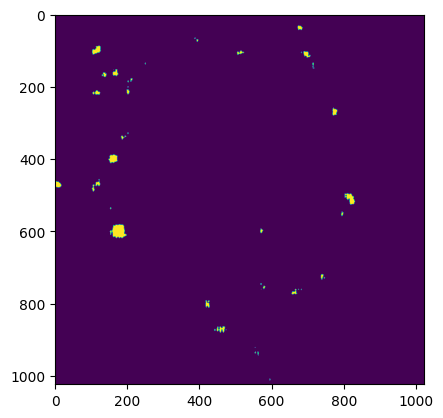

In [54]:

plt.imshow(a)